# Note: how to restore so this notebook works
QMLA must have 
- thesis_demos/demo.py --> a copy of demos/lattice_demos.py
- exploration_strategies/rating_system.py --> copy of shared_functionality/rating_system.py
- shared_functionality/measurement_probabilities --> copy of shared_functionality/expectation_values with default_expectation_value renamed to default_measurement_probability
- shared_functionality/model_constructors -> copy to qmla.construct_models with BaseModel -> Operator

In [1]:
import sys
import os
import numpy as np
import pickle
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
import itertools
from matplotlib.lines import Line2D
import qinfer as qi
from scipy import linalg
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import PercentFormatter
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.markers as mmark
from matplotlib.ticker import PercentFormatter

from lfig import LatexFigure
sys.path.append("/home/bf16951/QMD")
import qmla

%matplotlib inline

In [2]:
results_dir = os.path.join(
    "/home/bf16951/thesis/qmla_run_data/", "Nov_18/13_56"
)
run_id = '001'
qmla_class_file = os.path.join(results_dir, 'qmla_class_{}.p'.format(run_id))

In [3]:
def load_results(
    results_time,
    results_folder=os.path.abspath("/home/bf16951/thesis/qmla_run_data/"),
    run_id='001'
):

    results_dir = os.path.join(
        results_folder, 
        results_time
    )

    try:
        results_file = os.path.join(results_dir, 'results_{}.p'.format(run_id))
        res = pickle.load(open(results_file, 'rb'))
    except:
        results_file = os.path.join(results_dir, 'results_m1_q{}.p'.format(run_id))
        res = pickle.load(open(results_file, 'rb'))


    true_params = pickle.load(open(os.path.join(results_dir, 'run_info.p'), 'rb')) 
    qmla_class_file = os.path.join(results_dir, 'qmla_class_{}.p'.format(run_id))
    plot_probes = pickle.load(open(os.path.join(results_dir, 'plot_probes.p'), 'rb'))
    true_measurements = pickle.load(open(os.path.join(results_dir, 'system_measurements.p'), 'rb'))
    q = pickle.load(open(qmla_class_file, 'rb'))
    try:
        q2 = pickle.load(open(os.path.join(results_dir, 'qmd_class_002.p'), 'rb'))
    except:
        pass
    es = q.exploration_class
    try:
        combined_datasets = os.path.join(results_dir, 'combined_datasets')
        evaluation_data = pickle.load(open(os.path.join(results_dir, 'evaluation_data.p' ), 'rb'))
        storage = pickle.load(open(os.path.join(results_dir, 'storage_{}.p'.format(run_id)), 'rb'))
        system_probes = pickle.load(open(
            os.path.join(results_dir, 'training_probes', 'system_probes.p'),
            'rb'
        ))
        ga = gr.genetic_algorithm
    except:
        pass

    try:
        # these are only available if analysis has been performed
        champ_info = pickle.load(open(os.path.join(results_dir, 'champion_models',  'champions_info.p' ), 'rb'))
        bf = pd.read_csv(os.path.join(combined_datasets,  'bayes_factors.csv' ))
        fitness_df = pd.read_csv(os.path.join(combined_datasets,  'fitness_df.csv' ))
        combined_results = pd.read_csv(os.path.join(results_dir, 'combined_results.csv'))
        correlations = pd.read_csv(
            os.path.join(combined_datasets, "fitness_correlations.csv")
        )
        fitness_by_f_score = pd.read_csv(
            os.path.join(combined_datasets, 'fitness_by_f_score.csv')
        )
    except:
        pass
    
    results = {
        'qmla_instance' : q, 
        'exploration_strategy' : es, 
        'results_dir' : results_dir,
        'true_measurements' : true_measurements, 
        'true_params' : true_params
    }
    
    return results

In [4]:
results = load_results("Nov_18/13_56")
q = results['qmla_instance']
q.true_param_dict.update({
    "pauliSet_x_1_d3" : 0.2, 
    "pauliSet_x_2_d3" : 0.2, 
    "pauliSet_x_3_d3" : 0.2, 
    "pauliSet_zJz_1J2_d3" : 0.8, 
    "pauliSet_zJz_1J3_d3" : 0.8,
    "pauliSet_zJz_2J3_d3" : 0.8
})
es = results['exploration_strategy']
results_dir = results['results_dir']

In [5]:
pickle.load(open(
    "/home/bf16951/thesis/qmla_run_data/Nov_18/13_56/qmla_class_001.p", "rb"
))

In [6]:
summary_labels = {
    'pauliLikewise_lx_1_2_3_d3': r"$h$",
    'pauliLikewise_lz_1J2_1J3_2J3_d3': r"$J$",
    'pauliSet_x_1_d3': r"$h_1$",
    'pauliSet_x_2_d3': r"$h_2$",
    'pauliSet_x_3_d3': r"$h_3$",
    'pauliSet_zJz_1J2_d3': r"$J_{1,2}$",
    'pauliSet_zJz_1J3_d3': r"$J_{1,3}$",
    'pauliSet_zJz_2J3_d3': r"$J_{2,3}$", 

}

# Fully parameterised

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


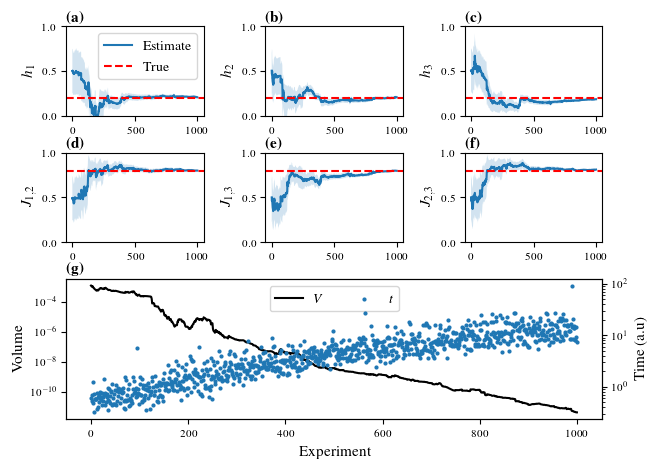

In [11]:
mod = q.get_model_storage_instance_by_id(1)

param_order = [
    "pauliSet_x_1_d3" ,
    "pauliSet_x_2_d3",
    "pauliSet_x_3_d3" ,
    "pauliSet_zJz_1J2_d3" ,
    "pauliSet_zJz_1J3_d3" ,
    "pauliSet_zJz_2J3_d3" ,
]
terms = param_order
param_legend="inside"
save_path = os.path.join(
    "..", "theoretical_study", "figures",  
    "fully_param_ising_qhl.pdf"
)

num_terms = len(terms)

extra_plots = [
    'volume', 
]
resample_colour = 'grey'

ncols = int(np.ceil(np.sqrt(num_terms)))
nrows_for_params = int(np.ceil(num_terms / ncols))
nrows = nrows_for_params + len(extra_plots)
height_ratios = [1]*nrows_for_params
height_ratios.extend([ncols*0.52]*len(extra_plots))


lf = LatexFigure(
    fraction=1,
    use_gridspec=True, 
    gridspec_layout=(nrows, ncols),
    gridspec_params={
        'height_ratios' : height_ratios,
        'hspace' : 0.35,
        'wspace' : 0.45,
    }
)

# Parameter estimates
for term in terms:
    ax = lf.new_axis()
    estimates = mod.track_param_estimate_v_epoch[term]
    uncertainty = mod.track_param_uncertainty_v_epoch[term]
    lower_bound = estimates - uncertainty
    upper_bound = estimates + uncertainty

    epochs = range(len(estimates))

    ax.plot(epochs, estimates, label='Estimate')
    ax.fill_between(
        epochs,
        lower_bound,
        upper_bound,
        alpha=0.2,
#             label='Uncertainty'
    )

    if term in q.true_param_dict:
        true_param = q.true_param_dict[term]
        ax.axhline(true_param, color='red', ls='--', label='True')

    try:
        term_latex = mod.exploration_class.latex_name(term)
#         ax.set_title(term_latex)
        ax.set_ylabel(term_latex)
        ax.set_ylabel(summary_labels[term])
    except BaseException:
        mod.log_print(["Failed to get latex name"])
        raise
    # ax.set_ylabel('Parameter')
    ax.set_xlabel('Epoch')

    ax.set_xlabel("")
    ax.set_ylim(0,1)
    ax.set_yticks([0, 0.5, 1])
    
    if ax.row == 0 and ax.col == 0:
        if param_legend == "outside":
            ax.legend(
                bbox_to_anchor=(1.25, 1.1)
            )
        else: 
            ax.legend(
                loc = 'upper right'
            )
#     ax.semilogy()
# Volume and experimental times
ax = lf.new_axis(
    span=(1, 'all')
)

exps = sorted(mod.volume_by_epoch.keys())
ax.plot(
    exps,
    [mod.volume_by_epoch[k] for k in exps],
    label=r"$V$",
    color='k'
)

ax.set_ylabel('Volume')
ax.set_xlabel('Experiment')
ax.set_yscale('log')

time_ax = ax.twinx()
times = qmla.utilities.flatten(mod.times_learned_over)
if q.num_experiments > 100:
    s = 4  # size of time dots
else:
    s = 7
time_ax.scatter(
    exps[1:],
    times,
    label=r"$t$",
    s=s,
)
time_ax.set_ylabel('Time (a.u)')
time_ax.semilogy()

handles, labels = ax.get_legend_handles_labels()
t_handles, t_labels = time_ax.get_legend_handles_labels()
handles.extend(t_handles)
labels.extend(t_labels)

ax.legend(
    handles, labels, 
    ncol=2, 
    loc='upper center'
    # bbox_to_anchor=(0.4, 1.25)
)

lf.fig.tight_layout()
# lf.save(save_path)

# 2 parameter Ising

In [12]:
es.latex_model_naming_function

<function qmla.shared_functionality.latex_model_names.lattice_pauli_likewise_concise>

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


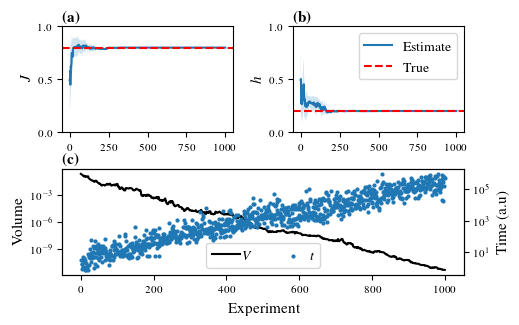

In [19]:
mod = q.get_model_storage_instance_by_id(2)
terms = mod.track_param_estimate_v_epoch.keys()
param_legend="inside"
save_path = os.path.join(
    "..", "theoretical_study", "figures",  
    "standard_ising_qhl.pdf"
)

num_terms = len(terms)

extra_plots = [
    'volume', 
]
resample_colour = 'grey'

ncols = int(np.ceil(np.sqrt(num_terms)))
nrows_for_params = int(np.ceil(num_terms / ncols))
nrows = nrows_for_params + len(extra_plots)
height_ratios = [1]*nrows_for_params
height_ratios.extend([ncols*0.7]*len(extra_plots))


lf = LatexFigure(
    fraction=3/4,
#     fraction = 1, 
    use_gridspec=True, 
    gridspec_layout = (2, 2),
#     gridspec_layout=(nrows, ncols),
    gridspec_params={
#         'height_ratios' : height_ratios,
        'hspace' : 0.35,
        'wspace' : 0.35,
    }
)

# Parameter estimates
for term in terms:
    ax = lf.new_axis()
    estimates = mod.track_param_estimate_v_epoch[term]
    uncertainty = mod.track_param_uncertainty_v_epoch[term]
    lower_bound = estimates - uncertainty
    upper_bound = estimates + uncertainty

    epochs = range(len(estimates))

    ax.plot(epochs, estimates, label='Estimate')
    ax.fill_between(
        epochs,
        lower_bound,
        upper_bound,
        alpha=0.2,
#             label='Uncertainty'
    )

    if term in q.true_param_dict:
        true_param = q.true_param_dict[term]
        ax.axhline(true_param, color='red', ls='--', label='True')

    try:
        term_latex = mod.exploration_class.latex_name(term)
#         ax.set_title(term_latex)
        ax.set_ylabel(term_latex)
        ax.set_ylabel(summary_labels[term])
    except BaseException:
        mod.log_print(["Failed to get latex name"])
        raise
    # ax.set_ylabel('Parameter')
    ax.set_xlabel('Epoch')

    ax.set_xlabel("")
    ax.set_ylim(0,1)
    ax.set_yticks([0, 0.5, 1])
    
    if ax.row == 0 and ax.col == lf.gridspec_layout[1]-1:
        if param_legend == "outside":
            ax.legend(
                bbox_to_anchor=(1.25, 1.1)
            )
        else: 
            ax.legend(
                loc = 'upper right'
            )
# Volume and experimental times
# ax = lf.new_axis(
#     span=(1, 'all')
# )
ax = lf.new_axis(span=(1, 2) )

exps = sorted(mod.volume_by_epoch.keys())
ax.plot(
    exps,
    [mod.volume_by_epoch[k] for k in exps],
    label=r"$V$",
    color='k'
)

ax.set_ylabel('Volume')
ax.set_xlabel('Experiment')
ax.set_yscale('log')

time_ax = ax.twinx()
times = qmla.utilities.flatten(mod.times_learned_over)
if q.num_experiments > 100:
    s = 4  # size of time dots
else:
    s = 7
time_ax.scatter(
    exps[1:],
    times,
    label=r"$t$",
    s=s,
)
time_ax.set_ylabel('Time (a.u)')
time_ax.semilogy()

handles, labels = ax.get_legend_handles_labels()
t_handles, t_labels = time_ax.get_legend_handles_labels()
handles.extend(t_handles)
labels.extend(t_labels)

ax.legend(
    handles, labels, 
    ncol=2, 
#     loc = "center right",
    handletextpad=0.25,
    labelspacing=0.2,
    loc='lower center'
    # bbox_to_anchor=(0.4, 1.25)
)

lf.fig.tight_layout()
# lf.save(save_path)

# Plot dynamics of both models

In [ ]:
times = sorted(results['true_measurements'].keys())
msmts = [results['true_measurements'][t] for t in times]

lf = LatexFigure(fraction=0.75)
ax = lf.new_axis(auto_label=False)
times = sorted(model.expectation_values.keys())

std_model = q.get_model_storage_instance_by_id(2)
fully_param_model = q.get_model_storage_instance_by_id(1)

ax.plot(
    times, 
    [std_model.expectation_values[t] for t in times],
    c = 'blue',
    label = 'Standard'
)
ax.plot(
    times, 
    [fully_param_model.expectation_values[t] for t in times],
    c = 'green',
    ls = '--',
    lw = 2, 
    label = 'Fully parameterised'
)

ax.scatter(
    times, 
    msmts, 
    c = 'red',
    s = 15, 
    label='$Q$'
)
ax.set_ylim(0, 1.2)
ax.set_yticks([0, 0.5, 1])
ax.set_ylabel(r"$| \langle + | e^{-i\hat{H}_0 \ t} | + \rangle |^2$")
ax.set_xlabel(r"Time ($a.u$)")
ax.set_xticks([0, 5, 10, 15])
ax.legend(ncol=3, loc = 'upper center')

# save_path = os.path.join(
#     results_dir, 
#     "dynamics.pdf"
# )
save_path = os.path.join(
    "..", "theoretical_study", "figures",  
    "dynamics.pdf"
)

lf.save(save_path)

